# **1. Import the libraries**

In [ ]:
!pip install joblib

In [ ]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# **2. Load the dataset and add headers**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Product_Recommendation_System /ratings_Electronics (1).csv',names=columns)

In [ ]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


**Dropping the timestamp column**

In [ ]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [ ]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [ ]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7824482
Number of columns:  3


In [ ]:
#Check the datatypes
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [ ]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:50000,0:]

In [ ]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     50000 non-null  object 
 1   productId  50000 non-null  object 
 2   ratings    50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()

count    50000.00000
mean         4.03524
std          1.35555
min          1.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: ratings, dtype: float64

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


# **Handling Missing values**

In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


# **Ratings**

In [ ]:
!pip install -U seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


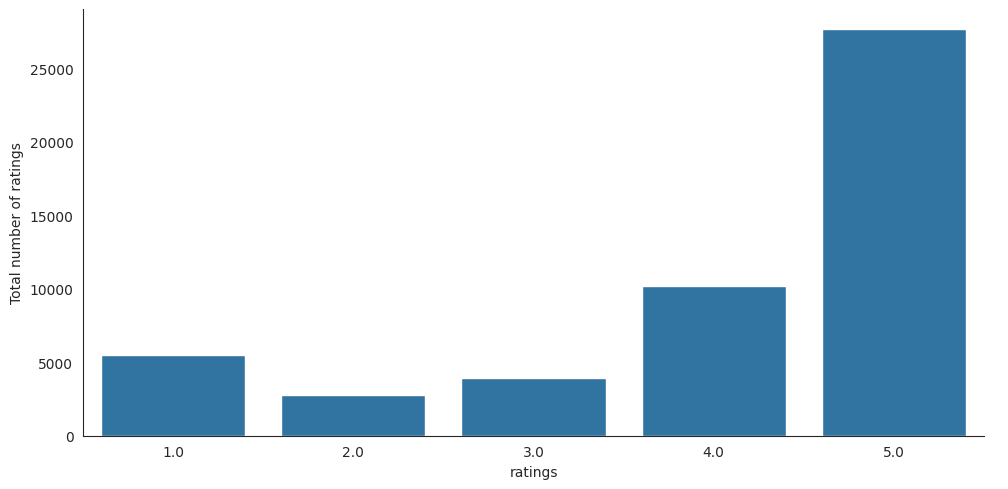

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x='ratings',
                    kind='count',
                    data=electronics_df1,
                    aspect=2.0)
    g.set_ylabels("Total number of ratings")

# **Users and products**

In [ ]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  46554
Number of unique product in Raw data =  3446


# **3. Taking the subset of dataset to make it less sparse/ denser.**

In [ ]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A231WM2Z2JL0U3    37
AY8Q1X7G96HV5     31
ALUNVOQRXOZIA     20
A1NVD0TKNS1GT5    19
A243HY69GIAHFI    18
A1RPTVW5VEOSI     17
A1ISUNUWG0K02V    16
A1MJMYLRTZ76ZX    16
A7Y6AVS576M03     15
A3MEIR72XKQY88    15
dtype: int64


In [ ]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 219
Number of unique users in the final data =  11
Number of unique products in the final data =  11


# **ratings analysis in final dataset**

In [ ]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [ ]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (11, 186)


In [ ]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  219
possible_num_of_ratings =  2046
density: 10.70%


# **4. Splitting the data**

In [ ]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
17509,AY8Q1X7G96HV5,B00000JSES,4.0
11968,A243HY69GIAHFI,B00000J3Q7,3.0
35533,A1RPTVW5VEOSI,B00003WGP5,5.0
31480,A1NVD0TKNS1GT5,B00002JXFH,4.0
13526,A23ZO1BVFFLGHO,B00000J570,5.0


In [ ]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (153, 3)
Shape of testing data:  (66, 3)


# **5. Building Collaborative Filtering recommender model.**

In [ ]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,17509,AY8Q1X7G96HV5,B00000JSES,4.0
1,11968,A243HY69GIAHFI,B00000J3Q7,3.0
2,35533,A1RPTVW5VEOSI,B00003WGP5,5.0
3,31480,A1NVD0TKNS1GT5,B00002JXFH,4.0
4,13526,A23ZO1BVFFLGHO,B00000J570,5.0


# **User Based Collaborative Filtering model**

In [ ]:
# Matrix with row per 'user' and column per 'item'
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [ ]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (11, 186)


In [ ]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,4


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


**Singular Value Decomposition**

In [ ]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df.to_numpy(), k=10)

In [ ]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
0,-0.005077,-0.010023,0.219864,-0.010023,-0.020310,-0.006562,2.962929,0.026594,4.938216,4.938216,...,-0.025387,0.026594,0.026594,0.219864,0.021275,-0.008018,-0.006014,-0.008018,0.026594,-0.008018
1,-0.000261,-0.000515,0.011300,-0.000515,-0.001044,-0.000337,-0.001905,0.001367,-0.003176,-0.003176,...,-0.001305,0.001367,0.001367,0.011300,0.001093,-0.000412,-0.000309,-0.000412,0.001367,-0.000412
2,-0.016300,-0.032177,0.705839,-0.032177,-0.065201,-0.021066,-0.119009,0.085374,-0.198349,-0.198349,...,-0.081502,0.085374,0.085374,0.705839,0.068299,-0.025742,-0.019306,-0.025742,0.085374,-0.025742
3,0.018068,0.035667,4.217599,0.035667,0.072274,0.023351,0.131918,-0.094635,0.219864,0.219864,...,0.090342,-0.094635,-0.094635,4.217599,-0.075708,0.028534,0.021400,0.028534,-0.094635,0.028534
4,0.002185,0.004314,-0.094635,0.004314,0.008742,0.002824,0.015956,4.988553,0.026594,0.026594,...,0.010927,4.988553,4.988553,-0.094635,3.990843,0.003451,0.002588,0.003451,4.988553,0.003451


In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0
    user_idx = userID-1
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00001P4XA                  0.0          1.526746
B00004T1WX                  0.0          1.526746
B00004T1WZ                  0.0          1.526746
B00000JYLO                  0.0          1.526746
B00000J4ER                  0.0          1.526746


In [ ]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00000J061                  0.0          0.038989
B00003WGP5                  0.0          0.038989
B00004RERZ                  0.0          0.038989
B00001QHP5                  0.0          0.038989
B00004TH2W                  0.0          0.038989


In [ ]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00004TH2W                  0.0          1.526746
B00004RIPE                  0.0          1.526746
B00001QHP5                  0.0          1.526746
B00003WGP5                  0.0          1.526746
B00000J061                  0.0          1.526746


# **7. Evaluation of Collabrative recommendation model**

In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
1400599997    0.090909
B00000DM9M    0.454545
B00000J061    0.454545
B00000J08C    0.454545
B00000J0A2    0.363636
dtype: float64

In [ ]:
# Predicted ratings
preds_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
0,-0.005077,-0.010023,0.219864,-0.010023,-0.020310,-0.006562,2.962929,0.026594,4.938216,4.938216,...,-0.025387,0.026594,0.026594,0.219864,0.021275,-0.008018,-0.006014,-0.008018,0.026594,-0.008018
1,-0.000261,-0.000515,0.011300,-0.000515,-0.001044,-0.000337,-0.001905,0.001367,-0.003176,-0.003176,...,-0.001305,0.001367,0.001367,0.011300,0.001093,-0.000412,-0.000309,-0.000412,0.001367,-0.000412
2,-0.016300,-0.032177,0.705839,-0.032177,-0.065201,-0.021066,-0.119009,0.085374,-0.198349,-0.198349,...,-0.081502,0.085374,0.085374,0.705839,0.068299,-0.025742,-0.019306,-0.025742,0.085374,-0.025742
3,0.018068,0.035667,4.217599,0.035667,0.072274,0.023351,0.131918,-0.094635,0.219864,0.219864,...,0.090342,-0.094635,-0.094635,4.217599,-0.075708,0.028534,0.021400,0.028534,-0.094635,0.028534
4,0.002185,0.004314,-0.094635,0.004314,0.008742,0.002824,0.015956,4.988553,0.026594,0.026594,...,0.010927,4.988553,4.988553,-0.094635,3.990843,0.003451,0.002588,0.003451,4.988553,0.003451


In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
1400599997    0.088513
B00000DM9M    0.449816
B00000J061    0.558292
B00000J08C    0.449816
B00000J0A2    0.354053
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(186, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400599997,0.090909,0.088513,0
B00000DM9M,0.454545,0.449816,1
B00000J061,0.454545,0.558292,2
B00000J08C,0.454545,0.449816,3
B00000J0A2,0.363636,0.354053,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.05854 



# **8. Getting top - K ( K = 5) recommendations.**

In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00004TH2W                  0.0          0.023351
B00004RIPE                  0.0          0.023351
B00004RERZ                  0.0          0.023351
B00004S9WQ                  0.0          0.023351
B00001QHP5                  0.0          0.023351




---


# **Summarising insights**

---





*   The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

*   Model-based Collaborative Filtering is a personalised recommender
system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.